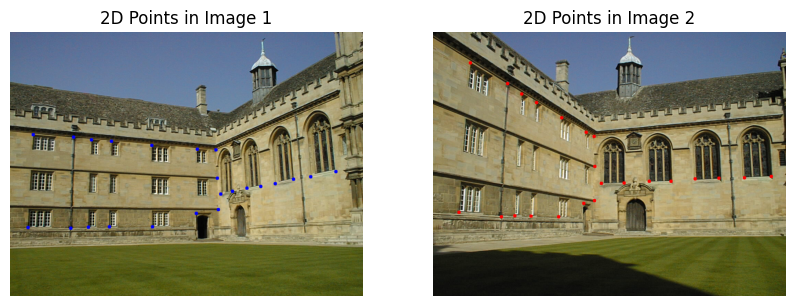

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# 카메라 내부 파라미터 설정
fx, fy = 1086, 1086
cx, cy = 512, 384
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])


# 이미지와 2D 포인트 파일 경로 설정
img1_path = '../two-view_reconstruction/hw5_data/003.jpg'
img2_path = '../two-view_reconstruction/hw5_data/005.jpg'
points1_path = '../two-view_reconstruction/hw5_data/003.csv'
points2_path = '../two-view_reconstruction/hw5_data/005.csv'

# 이미지 로드
img1 = cv.imread(img1_path)
img2 = cv.imread(img2_path)
assert img1 is not None and img2 is not None, "이미지를 로드할 수 없습니다."

# 2D 포인트 로드
points1 = np.loadtxt(points1_path, delimiter=',')
points2 = np.loadtxt(points2_path, delimiter=',')

# 이미지에 포인트 시각화 함수
def plot_points(img, points, color=(0, 255, 0)):
    img_with_points = img.copy()
    for x, y in points:
        cv.circle(img_with_points, (int(x), int(y)), 5, color, -1)
    return img_with_points

# 두 이미지에 포인트 시각화
img1_with_points = plot_points(img1, points1, color=(255, 0, 0))  # 빨간색 포인트
img2_with_points = plot_points(img2, points2, color=(0, 0, 255))  # 파란색 포인트

# 시각화 결과 출력
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img1_with_points, cv.COLOR_BGR2RGB))
plt.title("2D Points in Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(img2_with_points, cv.COLOR_BGR2RGB))
plt.title("2D Points in Image 2")
plt.axis('off')
plt.show()


In [2]:
# 필수 행렬(Essential Matrix) 계산
E, _ = cv.findEssentialMat(points1, points2, K, method=cv.RANSAC, prob=0.999, threshold=1.0)
print("Essential Matrix (E):\n", E)

# 회전(R) 및 변환(t) 추출
_, R, t, _ = cv.recoverPose(E, points1, points2, K)
print("Rotation Matrix (R):\n", R)
print("Translation Vector (t):\n", t)

Essential Matrix (E):
 [[-0.00726234 -0.20269546  0.02993239]
 [-0.35727258  0.00542266 -0.60968352]
 [ 0.06760755  0.67332355 -0.02536486]]
Rotation Matrix (R):
 [[ 0.67198023 -0.13169433 -0.72876551]
 [ 0.12448612  0.99014596 -0.06414189]
 [ 0.73003135 -0.04761911  0.68175263]]
Translation Vector (t):
 [[0.95704322]
 [0.03501157]
 [0.28782367]]


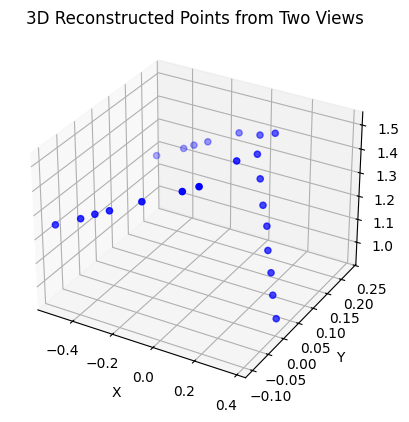

In [3]:
# 투영 행렬 설정
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # 첫 번째 카메라의 투영 행렬
P2 = np.hstack((R, t))  # 두 번째 카메라의 투영 행렬
P1 = K @ P1
P2 = K @ P2

# 3D 포인트 재구성
points4D = cv.triangulatePoints(P1, P2, points1.T, points2.T)
points3D = points4D / points4D[3]  # 동차 좌표를 유클리드 좌표로 변환

# 3D 포인트 시각화
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points3D[0], points3D[1], points3D[2], c='b', marker='o')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.title("3D Reconstructed Points from Two Views")
plt.show()

Reconstructed 3D points:
 [[-0.51313227 -0.09798761  1.2516307 ]
 [-0.51120014  0.20404403  1.20675597]
 [-0.39323466 -0.09320538  1.30136654]
 [-0.38780219  0.21600582  1.25344652]
 [-0.33660331 -0.08480343  1.32395098]
 [-0.33561241  0.21667608  1.2788599 ]
 [-0.27092289 -0.08077976  1.34964337]
 [-0.26914285  0.22003581  1.30488182]
 [-0.13108973 -0.0696325   1.40794196]
 [-0.12452905  0.22946908  1.36584985]
 [ 0.04212783 -0.05724387  1.47653584]
 [ 0.03698864  0.19022728  1.43463071]
 [ 0.11838372 -0.05570998  1.51252606]
 [ 0.1221357   0.05695535  1.491167  ]
 [ 0.12471453  0.18063936  1.47196428]
 [ 0.13263261  0.11651205  1.45612184]
 [ 0.16893752  0.10221921  1.37906777]
 [ 0.20929435  0.08503462  1.29876152]
 [ 0.2438671   0.07518421  1.23168317]
 [ 0.27334551  0.05949285  1.15585236]
 [ 0.31086437  0.04512547  1.08902808]
 [ 0.33572838  0.03503922  1.01288481]
 [ 0.37588143  0.01992467  0.94275117]]


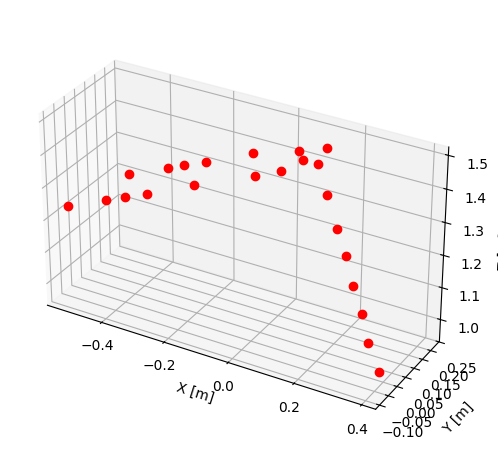

In [9]:
# 투영 행렬 설정
P1 = K @ np.eye(3, 4, dtype=np.float32)  # 첫 번째 카메라의 투영 행렬
Rt = np.hstack((R, t))  # R과 t를 결합하여 두 번째 카메라의 Rt 행렬 생성
P2 = K @ Rt  # 두 번째 카메라의 투영 행렬

# 3D 포인트 재구성 (삼각 측량)
X = cv.triangulatePoints(P1, P2, points1.T, points2.T)
X /= X[3]  # 동차 좌표를 유클리드 좌표로 변환
X = X[:3].T  # X, Y, Z 좌표만 사용하도록 변환

# 3D 포인트 출력
print("Reconstructed 3D points:\n", X)

# 결과를 파일에 저장 (옵션)
output_file = '../two-view_reconstruction/hw5_data/triangulation_output.xyz'
np.savetxt(output_file, X, fmt='%.6f')

# Visualize the reconstructed 3D points
ax = plt.figure(layout='tight').add_subplot(projection='3d')
ax.plot(X[:,0], X[:,1], X[:,2], 'ro')
ax.set_aspect('equal')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.grid(True)
plt.show()